### Question 1 
#### Own Calibration

#### Task 1

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt 
import cv2

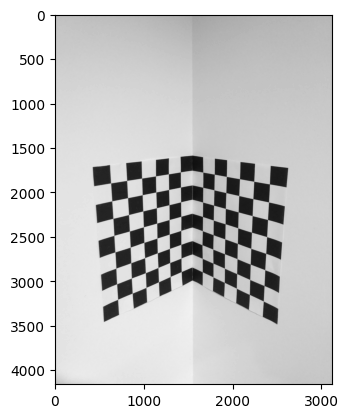

In [2]:
# reading the image
image = cv2.imread('./calib-object.jpg')

# converting the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# displaying the image
plt.imshow(gray_image, cmap='gray')

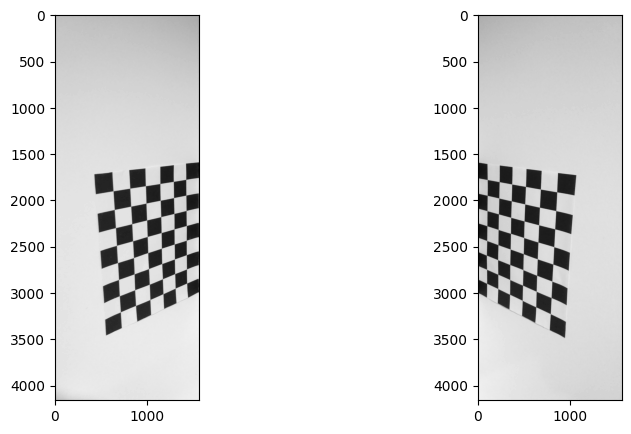

In [3]:
# dividing the image into 2 halves, because it is not detected otherwise.
left_half = gray_image[:, :int(gray_image.shape[1]/2)]
right_half = gray_image[:, int(gray_image.shape[1]/2):]

# displaying the left half and right half
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_half, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(right_half, cmap='gray')
plt.show()


In [4]:
# finding the chessboard corners of left half first
ret_left, corners_left = cv2.findChessboardCorners(left_half, (6,8), None)

# finding the chessboard corners of right half
ret_right, corners_right = cv2.findChessboardCorners(right_half, (6,8), None)

print(ret_left, ret_right)

True True


In [5]:
# using corner subpix to refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners_left = cv2.cornerSubPix(left_half, corners_left, (11,11), (-1,-1), criteria)
corners_right = cv2.cornerSubPix(right_half, corners_right, (11,11), (-1,-1), criteria)


In [6]:
# drawing the corners on the images
radius = 5
color = (255, 0, 0)
thickness = 50

left_half = cv2.cvtColor(left_half, cv2.COLOR_GRAY2BGR)
right_half = cv2.cvtColor(right_half, cv2.COLOR_GRAY2BGR)

for corner in corners_left:
    coord = (int(corner[0][0]), int(corner[0][1]))
    cv2.circle(img=left_half, center=coord, radius=radius, color=color, thickness=thickness)

for corner in corners_right:
    coord = (int(corner[0][0]), int(corner[0][1]))
    cv2.circle(img=right_half, center=coord, radius=radius, color=color, thickness=thickness)




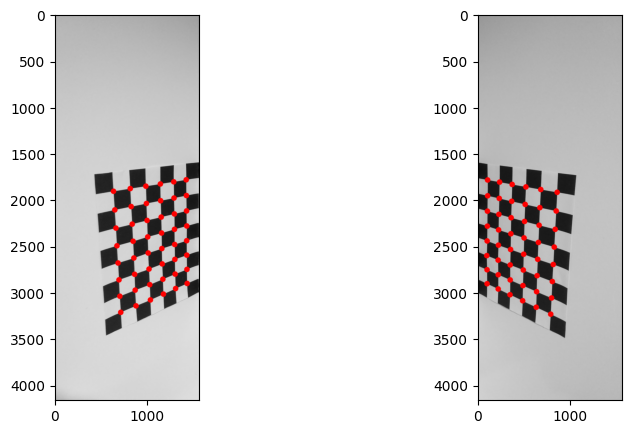

In [7]:
# displaying the images with corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_half)
plt.subplot(1, 2, 2)
plt.imshow(right_half)
plt.show()


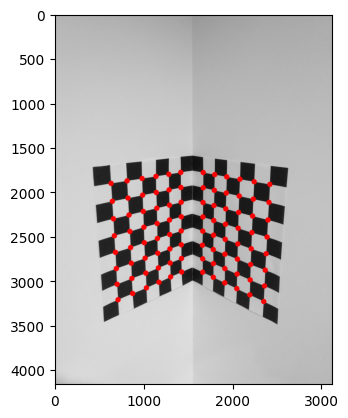

In [8]:
# combining the images
combined_image = np.concatenate((left_half, right_half), axis=1)

# combining the pixels 
width = left_half.shape[1]

for corner in corners_right:
    corner[0][0] += width

# displaying the combined image
plt.imshow(combined_image)

In [9]:
# concantenating the corners
corners = np.concatenate((corners_left, corners_right), axis=0)

#### Task 2

In [10]:
# we assume the bottom middle i.e. the right angle in wall to be place of world origin. 
cols = 8
rows = 10
squre_size = 2

object_points = []
image_points = []

counter = 0
step2 = rows -2
step1 = cols -2
for corners in corners_left:
    x = float(corners[0][0])
    y = float(corners[0][1])
    image_points.append([x, y])
    object_points.append([0, (step2) * squre_size, (step1 - counter) * squre_size])
    counter += 1

    if counter == 6:
        counter = 0
        step2 -= 1

counter = 0
step2 = rows -2
step1 = cols -2

for corners in corners_right:
    x = float(corners[0][0])
    y = float(corners[0][1])
    image_points.append([x, y])
    object_points.append([(counter+1) * squre_size, (step2) * squre_size, 0])
    counter += 1

    if counter == 6:
        counter = 0
        step2 -= 1

print(np.shape(object_points), np.shape(image_points))


(96, 3) (96, 2)


In [11]:
# making G of Gp = 0
G_list = []
l = len(object_points)
for index in range(l):
# Gp=0
    G = np.zeros((2,12))
    object_points_temp = object_points[index]
    object_points_temp = np.append(object_points_temp, 1)
    object_points_temp = np.float32(object_points_temp)
    image_points_temp = image_points[index]

    G[0, 0:4] = object_points_temp
    G[0, 8:12] = -1 * object_points_temp * image_points_temp[0]
    G[1, 4:8] = object_points_temp
    G[1, 8:12] = -1 * object_points_temp * image_points_temp[1]

    G_list.append(G)

# stacking the Gs
G = np.vstack(G_list)


In [12]:
# finding the P matrix, using Gp = 0
# We shall do Singular Value Decomposition. 
# The solution turns out to be the right-singular vector of A corresponding to the smallest singular value.
U, S, V = np.linalg.svd(G)
p = V[-1].reshape(3, 4) # this is the smallest singular value

P = p / p[2, 3]
P = P.reshape(3, 4)
print("P matrix using Gp=0:")
print(P)


P matrix using Gp=0:
[[ 3.10648626e+01 -7.42091530e+00 -7.90360282e+01  1.54215828e+03]
 [-1.64869656e+01 -8.52974063e+01 -1.63336490e+01  2.99267661e+03]
 [-1.49231365e-02 -4.69435130e-03 -1.44367094e-02  1.00000000e+00]]


In [13]:
# optimising P
from scipy.optimize import minimize

def projection_error(P, object_points, image_points):
    num_points = len(object_points)
    error = 0

    P_t = P.reshape(3, 4)

    for i in range(num_points):
        X = object_points[i]
        x, y = image_points[i]

        # Project 3D point to 2D image point
        X = np.append(X, 1)
        x_est = np.dot(P_t, X)
        x_est /= x_est[2]  # Normalization

        # Compute reprojection error
        error = error + np.sqrt((x_est[0] - x)**2 + (x_est[1] - y)**2)

    return error

p_Temp = P.reshape(12)
result = minimize(projection_error, p_Temp, args=(object_points, image_points))
P_optimized = result.x.reshape(3, 4)

print("P matrix using optimization:")
print(P_optimized)  

P matrix using optimization:
[[ 3.10559808e+01 -7.47672810e+00 -7.90059801e+01  1.54189897e+03]
 [-1.65938903e+01 -8.53286493e+01 -1.64785050e+01  2.99281568e+03]
 [-1.49514950e-02 -4.72061566e-03 -1.44902385e-02  1.00008183e+00]]


In [14]:
# randomly choosing few points to check their projections
indexes = np.random.choice(len(object_points), 5)

for index in indexes:
    object_point = object_points[index]
    object_point = np.append(object_point, 1)
    object_point = np.float32(object_point)
    image_point = image_points[index]
    image_point = np.float32(image_point)

    projection = np.dot(P_optimized, object_point)
    projection = projection / projection[2]
    projection = projection[:2]
    print("Projected point: ", projection)  
    print("Actual point: ", image_point)
    print("")

Projected point:  [ 991.079119   2219.95893811]
Actual point:  [ 990.8679 2219.496 ]

Projected point:  [1659.17952263 1782.11737434]
Actual point:  [1663.7769 1782.6426]

Projected point:  [ 977.23731622 1849.70767428]
Actual point:  [ 977.29614 1849.7886 ]

Projected point:  [2220.2982288  2270.92671331]
Actual point:  [2217.391  2271.7114]

Projected point:  [1165.11077148 3013.48883313]
Actual point:  [1166.7521 3015.4072]



In [15]:
# checking for error
error = 0
for i in range(len(object_points)):
    t = object_points[i]
    t = np.append(t,1)
    a = P_optimized@t
    a = a/a[2]
    a = a[:2]   
    b = image_points[i]
    diff =a-b
    ut = np.dot(diff, diff)
    ut = np.sqrt(ut)
    error = error + ut
print(error)


177.04271818382006


In [16]:
# finding the K, R and t
M = P_optimized[:, :3]
p_4 = P_optimized[:, 3]
MM = M@M.T
print(MM)
norm_factor = MM[2,2]


[[7.26232029e+03 1.42454001e+03 7.15776914e-01]
 [1.42454001e+03 7.82787672e+03 8.89684694e-01]
 [7.15776914e-01 8.89684694e-01 4.55798426e-04]]


In [17]:
# M_T M =  K_T K
MM1= MM / norm_factor
u = MM1[0, 2]
v = MM1[1, 2]
beta = np.sqrt(MM1[1, 1] - v**2)
alpa = np.sqrt(MM1[0, 0] - u**2)
K = np.array([[alpa, 0, u],[0, beta, v],[0, 0, 1]])

In [18]:
# Extract R (rotation matrix)
R = np.linalg.inv(K)@M
R = np.sqrt(norm_factor)*R
# Extract t (translation vector)
t = np.linalg.inv(K)@p_4

print("K matrix:")
print(K)
print("")
print("R matrix:")
print(R)
print("")
print("t vector:")
print(t)
print("")

K matrix:
[[3.66975335e+03 0.00000000e+00 1.57038040e+03]
 [0.00000000e+00 3.65567693e+03 1.95192577e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

R matrix:
[[ 3.17269963e-04 -3.69805243e-07 -3.27248895e-04]
 [ 7.35284317e-05 -4.44513741e-04  6.89442449e-05]
 [-3.19205988e-04 -1.00782483e-04 -3.09358423e-04]]

t vector:
[-0.00779615  0.28468877  1.00008183]



#### Task 3

In [19]:
# defining the world coordinates of wireframe
world_coords_wireframe = [ [0,0,0] , [14,0,0] , [14,18,0], [0,18,0] ,  [0, 18, 14] , [0,0,14]]

world_coords_wireframe = np.array(world_coords_wireframe)
print(world_coords_wireframe)

[[ 0  0  0]
 [14  0  0]
 [14 18  0]
 [ 0 18  0]
 [ 0 18 14]
 [ 0  0 14]]


In [20]:
# projected points in image
projected_points = []

for points in  world_coords_wireframe:
    point = np.append(points, 1)
    image_point = P_optimized@point
    image_point = image_point/image_point[2]
    image_point = image_point[:2]
    projected_points.append(image_point)

print(projected_points)

[array([1541.77280786, 2992.57079676]), array([2499.72235895, 3490.9429811 ]), array([2609.98607432, 1735.05694436]), array([1537.86617442, 1592.04773072]), array([ 422.93469937, 1721.5940758 ]), array([ 546.66977086, 3464.69210222])]


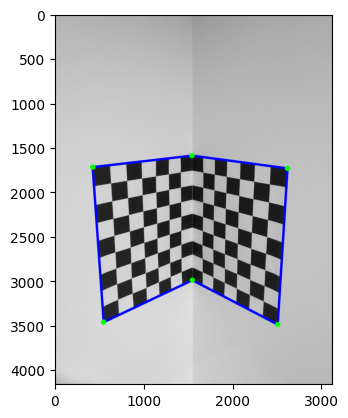

In [21]:
# drawing wireframe
radius = 5
color = (0, 255, 0)
thickness = 50

color_line = (0,0,255)
thickness_line = 25

wireframe_img = gray_image.copy()
wireframe_img = cv2.cvtColor(wireframe_img, cv2.COLOR_GRAY2BGR)

# plotting the wireframe
pp = []
for point in projected_points:
    x = int(point[0])
    y = int(point[1])
    a = (x,y)
    pp.append(a)

for i in range(len(projected_points) - 1):
    cv2.line( wireframe_img, pp[i], pp[i+1], color_line, thickness_line)
cv2.line( wireframe_img, pp[-1], pp[0], color_line, thickness_line)

# plotting the points
for point in projected_points:
    coord = (int(point[0]), int(point[1]))
    cv2.circle(img=wireframe_img, center=coord, radius=radius, color=color, thickness=thickness)



plt.imshow(wireframe_img)

The overlay of wireframe sits perfectly with the chessboard. We can also see how lines which are supposed to be parallel in real world, are not in wireframe and so it depicts that parallelism is not preserved.

#### Task 4

In [22]:
# Getting tilt, pan and roll

# rotation around x-axis
tilt = np.arcsin(-R[2, 0])
    
if np.cos(tilt) != 0:
    # rotation around y-axis
    pan = np.arctan2(R[2, 1],R[2, 2])

    # rotation around z-axis
    roll = np.arctan2(R[1, 0], R[0, 0] )

else:
    # roll - pan  = some constant, we assume pan = 0
    pan = 0
    roll = np.arctan2(R[0, 1], R[1, 1])    



print("Pan:", np.degrees(pan))
print("Tilt:", np.degrees(tilt))
print("Roll:", np.degrees(roll))


Pan: -161.95547734697703
Tilt: 0.018289156216770422
Roll: 13.048149570604863


The values are dependent on the world origin coordinates. Tilt is around x axis and roll is around z axis. As not high rotation around them, so value less. In case of Pan, its around y axis. As shown in the image, there is rotation in y axis, which has caused x axis and z axis to come out of the screen NOT perpendicularly or parallely

### Question 2
#### Camera Calibration

#### Task 1

In [23]:
# making the correct format 
obj1 = []
obj1.append(object_points)
obj1 = np.array(obj1)
obj1 = np.float32(obj1)
img1 = []
img1.append(image_points)
img1 = np.array(img1)
img1 = np.float32(img1)

width = gray_image.shape[1]
height = gray_image.shape[0]
initial_K = np.array([[width, 0, width/2] , [0,height,height/2] , [0,0,1]])

retval, K_inbuilt, dist, rvecs, tvecs = cv2.calibrateCamera(obj1, img1, gray_image.shape[::-1], initial_K, None, flags=  cv2.CALIB_USE_INTRINSIC_GUESS| cv2.CALIB_ZERO_TANGENT_DIST | cv2.CALIB_FIX_K3 | cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5 | cv2.CALIB_FIX_K6 | cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2)

In [24]:
# Comparing with inbuilt
print("K matrix inbuilt:")
print(K_inbuilt)
print("K matrix own:")
print(K)

rotation_matrix_inbuilt, _ = cv2.Rodrigues(rvecs[0])

# Construct projection matrix
projection_matrix_inbuilt = np.dot(K_inbuilt, np.hstack((rotation_matrix_inbuilt, tvecs[0])))

print("Projection matrix P inbuilt:")
print(projection_matrix_inbuilt)
print("Projection matrix own:")
print(P_optimized)




K matrix inbuilt:
[[3.67562396e+03 0.00000000e+00 1.54536124e+03]
 [0.00000000e+00 3.66049017e+03 1.95035851e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
K matrix own:
[[3.66975335e+03 0.00000000e+00 1.57038040e+03]
 [0.00000000e+00 3.65567693e+03 1.95192577e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Projection matrix P inbuilt:
[[ 1.43335041e+03 -3.45949315e+02 -3.70461584e+03  7.23235414e+04]
 [-7.96494062e+02 -4.00112591e+03 -7.48114485e+02  1.40335658e+05]
 [-7.08192786e-01 -2.21106198e-01 -6.70503562e-01  4.68954939e+01]]
Projection matrix own:
[[ 3.10559808e+01 -7.47672810e+00 -7.90059801e+01  1.54189897e+03]
 [-1.65938903e+01 -8.53286493e+01 -1.64785050e+01  2.99281568e+03]
 [-1.49514950e-02 -4.72061566e-03 -1.44902385e-02  1.00008183e+00]]


The values of K (intrinsic matrix) are close. But the values of projection matrix are different. This depends on the way they have been optimised

In [25]:
# inbuilt error
error = 0
for i in range(len(object_points)):
    t = object_points[i]
    t = np.append(t,1)
    a = projection_matrix_inbuilt@t
    a = a/a[2]
    a = a[:2]   
    b = image_points[i]
    diff =a-b
    ut = np.dot(diff, diff)
    ut = np.sqrt(ut)
    error = error + ut
print(error)


200.14286692708788


In [26]:
# projected points on basis of inbuilt
world_coords_wireframe = np.array(world_coords_wireframe, dtype = np.float32)
u = cv2.projectPoints(world_coords_wireframe, rvecs[0], tvecs[0], K_inbuilt, dist)
projected_points_inbuilt = np.array(u[0]).reshape(-1,2)

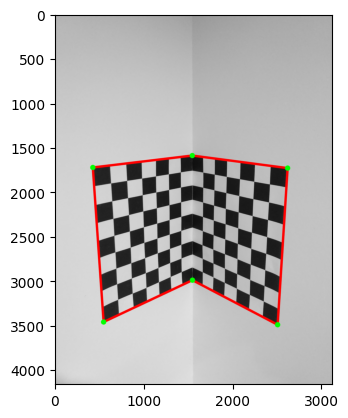

In [27]:
# drawing wireframe for inbuilt
radius = 5
color = (0, 255, 0)
thickness = 50

color_line = (255,0,0)
thickness_line = 25

wireframe_img_inbuilt = gray_image.copy()
wireframe_img_inbuilt = cv2.cvtColor(wireframe_img_inbuilt, cv2.COLOR_GRAY2BGR)

# plotting the wireframe
pp = []
for point in projected_points_inbuilt:
    x = int(point[0])
    y = int(point[1])
    a = (x,y)
    pp.append(a)

for i in range(len(projected_points_inbuilt) - 1):
    cv2.line( wireframe_img_inbuilt, pp[i], pp[i+1], color_line, thickness_line)
cv2.line( wireframe_img_inbuilt, pp[-1], pp[0], color_line, thickness_line)

# plotting the points
for point in projected_points_inbuilt:
    coord = (int(point[0]), int(point[1]))
    cv2.circle(img=wireframe_img_inbuilt, center=coord, radius=radius, color=color, thickness=thickness)



plt.imshow(wireframe_img_inbuilt)

The overlay of wireframe, using inbuilt OpenCV functions is correct. Just like our implementation in question 1, it is same.

#### Task 2

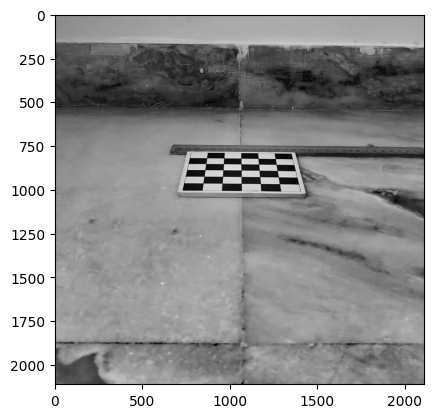

In [61]:
# reading the image
image = cv2.imread('./assign1.jpg')

# converting the image to grayscale 
gray_image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# displaying the image
plt.imshow(gray_image2, cmap='gray')

In [62]:
# finding corners
ret_2 , corners_2 = cv2.findChessboardCorners(gray_image2, (5,5), None)

# using corner subpix to refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners_2 = cv2.cornerSubPix(gray_image2, corners_2, (11,11), (-1,-1), criteria)

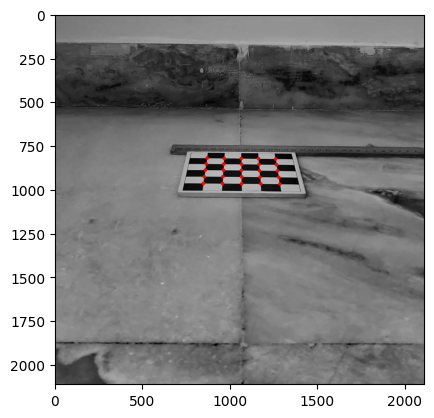

In [63]:
# painting corners
radius = 5
color = (255, 0, 0)
thickness = 10

gray_image2t = cv2.cvtColor(gray_image2, cv2.COLOR_GRAY2BGR)

for corner in corners_2:
    coord = (int(corner[0][0]), int(corner[0][1]))
    cv2.circle(img=gray_image2t, center=coord, radius=radius, color=color, thickness=thickness)

plt.imshow(gray_image2t)

In [64]:
# finding the world points. Assuming square size is 2. Assumed z is perpendicular to the board and into ground.
#  x is along ruler, y is coming towards us

# we assume the top left to be world origin. 
cols = 7
rows = 7
squre_size = 2

object_points2 = []
image_points2 = []

counter = 0
step2 = 0
step1 = cols -2
for corners in corners_2:
    x = float(corners[0][0])
    y = float(corners[0][1])
    image_points2.append([x, y])
    # object_points.append([0, (step2) * squre_size, (step1 - counter) * squre_size])
    object_points2.append([(counter) * squre_size, (step2) * squre_size, 0])
    counter += 1

    if counter == 5:
        step2  = step2 +1
        counter = 0

print(np.shape(object_points2), np.shape(image_points2))


(25, 3) (25, 2)


In [65]:
# printing corners
print(object_points2)
print(image_points2)

[[0, 0, 0], [2, 0, 0], [4, 0, 0], [6, 0, 0], [8, 0, 0], [0, 2, 0], [2, 2, 0], [4, 2, 0], [6, 2, 0], [8, 2, 0], [0, 4, 0], [2, 4, 0], [4, 4, 0], [6, 4, 0], [8, 4, 0], [0, 6, 0], [2, 6, 0], [4, 6, 0], [6, 6, 0], [8, 6, 0], [0, 8, 0], [2, 8, 0], [4, 8, 0], [6, 8, 0], [8, 8, 0]]
[[868.232177734375, 822.7749633789062], [966.1994018554688, 824.0820922851562], [1063.735595703125, 824.8431396484375], [1161.642333984375, 825.9716186523438], [1259.31591796875, 827.2499389648438], [863.2515258789062, 855.7289428710938], [963.7172241210938, 856.5491943359375], [1064.2510986328125, 857.5892944335938], [1164.6082763671875, 858.7734375], [1264.763671875, 860.0407104492188], [858.2391357421875, 890.6611938476562], [961.3514404296875, 891.6196899414062], [1064.515380859375, 892.8258056640625], [1167.7462158203125, 894.130859375], [1270.7633056640625, 895.4717407226562], [852.8016967773438, 928.0053100585938], [958.8016357421875, 928.5960693359375], [1065.13330078125, 929.688232421875], [1170.9515380859

In [66]:
# using camera inbuilt matrix

# making the correct format 
obj2 = []
obj2.append(object_points2)
obj2 = np.array(obj2)
obj2 = np.float32(obj2)
img2 = []
img2.append(image_points2)
img2 = np.array(img2)
img2 = np.float32(img2)

retval, K_inbuilt2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(obj2, img2, gray_image2.shape[::-1], None, None)

In [67]:
# making projection matrix

rotation_matrix_inbuilt2, _ = cv2.Rodrigues(rvecs2[0])

# Construct projection matrix
projection_matrix_inbuilt2 = np.dot(K_inbuilt2, np.hstack((rotation_matrix_inbuilt2, tvecs2[0])))

print("Projection matrix P inbuilt for image 2:")
print(projection_matrix_inbuilt2)

Projection matrix P inbuilt for image 2:
[[ 3.08422481e+03 -8.08745790e+02  5.98505927e+02  5.37363120e+04]
 [ 5.66293064e+01  3.83109840e+02  2.10450261e+03  5.08879558e+04]
 [ 2.49151555e-02 -7.72864846e-01  6.34081355e-01  6.20241970e+01]]


When coplanar, projection matrix computed might be wrong due to:
1. Several degenerate matrices giving the same result with similar accuracy. As all points lie in same plane, so less information on how to distinguish between them.
2. Not robust to small changes or noise.

In [68]:
# projected points on basis of inbuilt
world_coords_wireframe2 = [[-2,-2,0] , [10,-2,0] , [10,10,0] , [-2,10,0]]

world_coords_wireframe2 = np.array(world_coords_wireframe2, dtype = np.float32)
u = cv2.projectPoints(world_coords_wireframe2, rvecs2[0], tvecs2[0], K_inbuilt2, dist2)
projected_points_inbuilt2 = np.array(u[0]).reshape(-1,2)

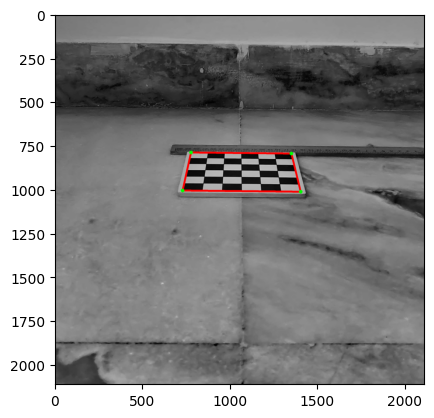

In [69]:
# drawing wireframe for inbuilt
radius = 5
color = (0, 255, 0)
thickness = 10

color_line = (255,0,0)
thickness_line = 10

wireframe_img_inbuilt2 = gray_image2.copy()

wireframe_img_inbuilt2 = cv2.cvtColor(wireframe_img_inbuilt2, cv2.COLOR_GRAY2BGR)

# plotting the wireframe
pp = []
for point in projected_points_inbuilt2:
    x = int(point[0])
    y = int(point[1])
    a = (x,y)
    pp.append(a)

for i in range(len(projected_points_inbuilt2) - 1):
    cv2.line( wireframe_img_inbuilt2, pp[i], pp[i+1], color_line, thickness_line)
cv2.line( wireframe_img_inbuilt2, pp[-1], pp[0], color_line, thickness_line)

# plotting the points
for point in projected_points_inbuilt2:
    coord = (int(point[0]), int(point[1]))
    cv2.circle(img=wireframe_img_inbuilt2, center=coord, radius=radius, color=color, thickness=thickness)


# plt.subplot(2,2,3)
plt.imshow(wireframe_img_inbuilt2)
plt.show()

#### Task 3

Projcted world origin:  (866, 820)
Actual world origin:  (868, 822)


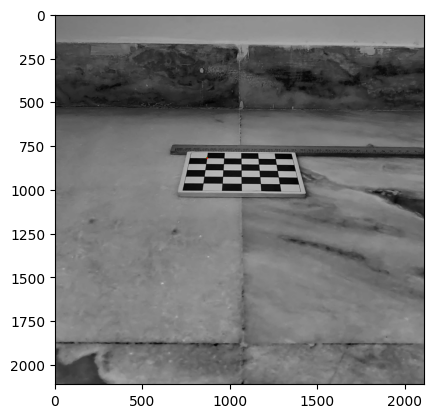

In [70]:
# world origin
world_origin_coords = [0,0,0,1]

image_origin_coords =  projection_matrix_inbuilt2@world_origin_coords
image_origin_coords = image_origin_coords/image_origin_coords[2]
image_origin_coords = image_origin_coords[:2]


# painting them on image
radius = 2
color = (0, 255, 0)
thickness = 5

world_center = gray_image2.copy()
world_center = cv2.cvtColor(world_center, cv2.COLOR_GRAY2BGR)
coord = (int(image_origin_coords[0]), int(image_origin_coords[1]))
print("Projcted world origin: ", coord)
cv2.circle(img=world_center, center=coord, radius=radius, color=color, thickness=thickness)

color = (255, 0, 0)
x= corners_2[0][0][0]
y = corners_2[0][0][1]
coord = (int(x), int(y))
print("Actual world origin: ", coord)
cv2.circle(img=world_center, center=coord, radius=radius, color=color, thickness=thickness)

plt.imshow(world_center)

My projected world origin(green) and actual world origin(red) lie on the same point. We can see it in the image above.

### Question 3
#### Moving the Chessboad

#### Task 1

In [71]:
# modified by shifting 10 cm to right
modified_world = []

for corner in world_coords_wireframe2:
    x = corner[0] + 10
    y = corner[1] 
    z = corner[2]
    temp = [x,y,z]
    modified_world.append(temp)

print(modified_world)

[[8.0, -2.0, 0.0], [20.0, -2.0, 0.0], [20.0, 10.0, 0.0], [8.0, 10.0, 0.0]]


In [72]:
# finding shifted points
projected_points_inbuilt2_shift = []
for points in  modified_world:
    point = np.append(points, 1)
    image_point = projection_matrix_inbuilt2@point
    image_point = image_point/image_point[2]
    image_point = image_point[:2]
    projected_points_inbuilt2_shift.append(image_point)

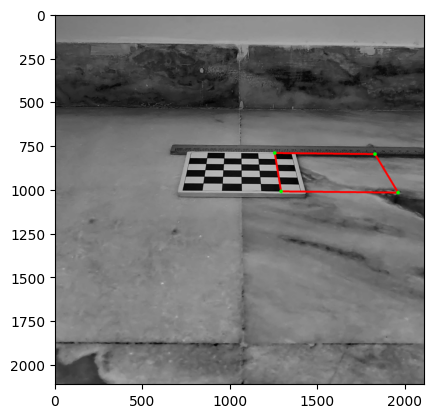

In [73]:
# drawing wireframe for inbuilt
radius = 5
color = (0, 255, 0)
thickness = 10

color_line = (255,0,0)
thickness_line = 10

wireframe_img_inbuilt2_shift = gray_image2.copy()
wireframe_img_inbuilt2_shift = cv2.cvtColor(wireframe_img_inbuilt2_shift, cv2.COLOR_GRAY2BGR)

# plotting the wireframe
pp = []
for point in projected_points_inbuilt2_shift:
    x = int(point[0])
    y = int(point[1])
    a = (x,y)
    pp.append(a)

for i in range(len(projected_points_inbuilt2_shift) - 1):
    cv2.line( wireframe_img_inbuilt2_shift, pp[i], pp[i+1], color_line, thickness_line)
cv2.line( wireframe_img_inbuilt2_shift, pp[-1], pp[0], color_line, thickness_line)

# plotting the points
for point in projected_points_inbuilt2_shift:
    coord = (int(point[0]), int(point[1]))
    cv2.circle(img=wireframe_img_inbuilt2_shift, center=coord, radius=radius, color=color, thickness=thickness)



plt.imshow(wireframe_img_inbuilt2_shift)

The wireframe looks consistent with what we expect. It is shifted 10cm to right.

#### Task 2

In [74]:
# making a meshgrid
num =1001
nx, ny = (num,num)
x = np.linspace(-2, 10, nx)
y = np.linspace(-2, 10, ny)
xv, yv = np.meshgrid(x, y)

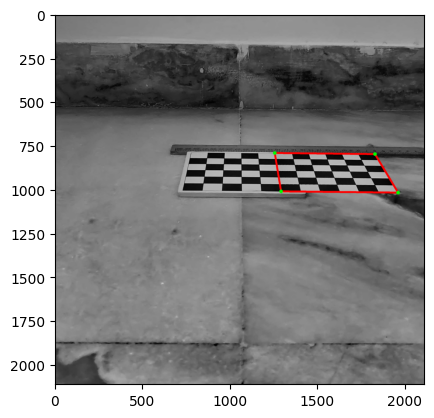

In [75]:
# making a shifted copy
shifted_copy = cv2.cvtColor(gray_image2, cv2.COLOR_GRAY2BGR)
shift = 10
for i in range(nx):
    for j in range(ny):
        x_oldw = xv[i][j]
        y_oldw = yv[i][j]

        old_coordsw = []
        old_coordsw = [x_oldw, y_oldw,0]

        point = np.append(old_coordsw, 1)
        image_pointoldw = projection_matrix_inbuilt2@point
        image_pointoldw = image_pointoldw/image_pointoldw[2]

        image_pointoldw = image_pointoldw[:2]

        xio = int(image_pointoldw[0])
        yio = int(image_pointoldw[1])

        newcoordsw = []
        newcoordsw = [x_oldw + shift, y_oldw,0]

        point = np.append(newcoordsw, 1)
        image_pointneww = projection_matrix_inbuilt2@point
        image_pointneww = image_pointneww/image_pointneww[2]

        image_pointneww = image_pointneww[:2]

        xin = int(image_pointneww[0])
        yin = int(image_pointneww[1])

        # replacing colors now

        value_at_old_place = gray_image2[yio][xio]
        shifted_copy[yin][xin] = value_at_old_place

# plotting the wireframe
pp = []
for point in projected_points_inbuilt2_shift:
    x = int(point[0])
    y = int(point[1])
    a = (x,y)
    pp.append(a)

for i in range(len(projected_points_inbuilt2_shift) - 1):
    cv2.line( shifted_copy, pp[i], pp[i+1], color_line, thickness_line)
cv2.line( shifted_copy, pp[-1], pp[0], color_line, thickness_line)

# plotting the points
for point in projected_points_inbuilt2_shift:
    coord = (int(point[0]), int(point[1]))
    cv2.circle(img=shifted_copy, center=coord, radius=radius, color=color, thickness=thickness)

plt.imshow(shifted_copy)





The overlay is consistent with what we expect. We have been succesful with shifting the pattern.

### Description of Problems and their algorithms

#### 1. Own Calibration
The problem was to find corners in image, camera's intrinsic and extrinsic parameters, overlaying wireframe over chessboard and finding angles of rotation for different axes.

The solution was:
- to find corners we can use Harris operators, which enable corner detection. We used OpenCV's function, called findChessboardcorners()
- to find the parameters, we used relation Gp = 0, where G is overdetermined and stacked matrix and p is vector form of Projection Matrix. We used SVD to decompose G and then find P (SVD allows least squares minimization). We also using "minimize" to minimise P. We then decomposed P into M and p4. M was later decomposed into K and R, using QR factorization and then naive way to determine K. We used K to get R and then t
- we first found the corner points of wireframe in world coordinats, projected them into image coordinates, and then connected them
- the rotation matrix was decomposed into pan, tilt and roll, using standard matrix

The results were accurate.

#### 2. OpenCV Calibration
The problem was to find camera matrix and wireframe using inbuilt functions, repeat it for another image and then find world origin in image coordinates.

The solution is:
- we used cameraCalibrate and projectPoints. We first gave our world points and image points and also an guess for estimated camera matrix. This was done as some of points fed were also having non-zero z. We also passed other flags to get skew and distortion zero. Once we got camera parameters, we found overlay by using them and projectPoints function to project world points to image. Comparing it with the methods of previous questions, the answer were same and corret
- We repeated for second image. We didn't have to pass any special flags this time, as the axes were taken such that z was zero for all object points.
- We found the image of world origin, by projecting (0,0,0) into image.

The results were accurate.

#### 3. Moving the Chessboard
The problem was to shift chessboard wireframe and then the pattern.

The solution is:
- To shift wireframe, we find coordinates of wireframe in world coordinate and then shift them by 10cm. We again reproject them onto image and get shifted wireframe.

- To shift pattern, we first form a meshgrid of world points on chessboard and also their corresponding image pxels. We then find another mesh which is 10cm away from old one in world coordinates. We project this onto image and get the coordinates of pixels which correspond to new shifted mesh. Now, we simply replace the values of these new shifted mesh pixels with old mesh pixels. We get shifted pattern.

The results were in agreement with our expectations.


#### Challenges faced in assignment:
1. Learning how to implement various OpenCV functions.
2. Learning how to implement calibration and then decompose it into various parts.
3. Learning how to move the pattern of the chessboard using meshgrid.